# Functional Encryption - Classification and information leakage



# 4 bis Tempering Collateral Learning (Extended results)


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import learn
from learn import show_results
# We now import from the collateral module
from learn import collateral

## 4.1 Simultaneous training

We will do the training in a single phase, as the collateral phase does not interfere with the main one.

We have reduced the collateral network size, it now just a simple FFN, to keep computation fast. We'll get back to CNN later don't worry!

The way the procedure is handled is the following: we alternate epochs, one on the main task which updates the quadratic and the character part of the network, and one on the collateral task which only updates the font family part of the network.

Therefore, if we call `Q` the quadratic part, `C` the net on top of `Q` used to predict characters and `F` the net for predicting families, the global network will be structured as follows:
```
  |
  Q
 / \
C   F
|   |
```

We will do a 2-phase process:
 - `Optimize: Q + C`
 - `Optimize: Freezed(Q) + F`

In [3]:
PRIVATE_OUTPUT_SIZE = 10
N_CHARS = 10
N_FONTS = 2

class Parser:
    def __init__(self):
        self.epochs = 10
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 300



In [4]:
def dual_learning_phase(model, cv):
    """
    Perform a dual learning phase
    """
    args = Parser()
    
    train_loader, test_loader = collateral.get_data_loaders(args, cv=cv)

    #optimizer = optim.Adam(model.parameters(), lr=args.lr)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.epochs + 1):
        collateral.train(args, model, train_loader, optimizer, epoch, 0, True, False, False, False)
        test_perf_char, test_perf_font = collateral.test(args, model, test_loader, False)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

In [5]:
results = {}

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def draw_paretoOLD(main_results, collateral_results):
    output_sizes = sorted([int(title.split(' ')[-1]) for title in main_results.keys()])
    
    main_results = {}
    collateral_results = {}
    for title, res in main_results.items():
        output_size = int(title.split(' ')[-1])      
        if output_size not in main_results.keys():
            main_results[output_size] = []
        main_results[output_size].append(res)
        
    for title, res in collateral_results.items():
        output_size = int(title.split(' ')[-1])   
        if output_size not in collateral_results.keys():
            collateral_results[output_size] = []
        collateral_results[output_size].append(res)
    
    y_m = []
    y_m_mean = []
    y_c = []
    y_c_mean = []
    for output_size in output_sizes:
        output_size_main_results = [np.mean(res[-4:]) for res in main_results[output_size]]
        y_m_mean.append(
            100 - np.mean(output_size_main_results)
        )
        y_m.append([100 - e for e in output_size_main_results])
        output_size_coll_results = [np.mean(res[-4:]) for res in collateral_results[output_size]]
        y_c_mean.append(
            100 - np.mean(output_size_coll_results)
        )
        y_c.append([100 - e for e in output_size_coll_results])

    plt.figure(figsize=(4, 4))
    plt.plot(y_m_mean, y_c_mean, 'o', label="Output size")
    for i, output_size in enumerate(output_sizes):
        plt.annotate(str(output_size), (y_m_mean[i] + 1, y_c_mean[i] - 1))
    plt.ylabel('Collateral Error')
    plt.xlabel('Main Task Error')
    #plt.title("Trade-off between the main and collateral accuracies")
    plt.legend()
    plt.savefig('Pareto_OutputSize_noSabotage.png')
    plt.show()

In [33]:
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches

In [66]:
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

def get_std_ellipsis(x, y):
    nstd = 1

    cov = np.cov(x, y)
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=w, height=h,
                  angle=theta, color='#3d3dff55')
    return ell

def draw_pareto(old_main_results, old_collateral_results):
    output_sizes = sorted(list(set([int(title.split(' ')[-1]) for title in old_main_results.keys()])))
    
    main_results = {}
    collateral_results = {}
    for title, res in old_main_results.items():
        output_size = int(title.split(' ')[-1])      
        if output_size not in main_results.keys():
            main_results[output_size] = []
        main_results[output_size].append(res)
        
    for title, res in old_collateral_results.items():
        output_size = int(title.split(' ')[-1])   
        if output_size not in collateral_results.keys():
            collateral_results[output_size] = []
        collateral_results[output_size].append(res)
    
    y_m = []
    y_m_mean = []
    y_c = []
    y_c_mean = []
    for output_size in output_sizes:
        output_size_main_results = [np.mean(res[-4:]) for res in main_results[output_size]]
        y_m_mean.append(
            100 - np.mean(output_size_main_results)
        )
        y_m.append([100 - e for e in output_size_main_results])
        output_size_coll_results = [np.mean(res[-4:]) for res in collateral_results[output_size]]
        y_c_mean.append(
            100 - np.mean(output_size_coll_results)
        )
        y_c.append([100 - e for e in output_size_coll_results])

    fig, ax = plt.subplots(figsize=(4, 3))
    
    all_main, all_coll = [], []
    for main_ys, coll_ys in zip(y_m, y_c):
        all_main += main_ys
        all_coll += coll_ys
        ell = get_std_ellipsis(main_ys, coll_ys)
        ax.add_artist(ell)
    
    print(y_m_mean)
    print(y_c_mean)
    # plt.scatter(all_main, all_coll, marker='o', s=2, c='#3d3dff',  zorder=9)
    scat = plt.scatter(y_m_mean, y_c_mean, marker='o', s=15, c='#3d3dff', label="Output size", zorder=10) # , c='r'
    for i, output_size in enumerate(output_sizes):
        plt.annotate(str(output_size), (y_m_mean[i] + 1, y_c_mean[i] - 1))
    plt.ylabel('Collateral Error')
    plt.xlabel('Main Task Error')
    plt.ylim(0, 50)
    plt.xlim(0, 50)
    # plt.title("Trade-off between the main and collateral accuracies")
    
    plt.legend(loc='lower right')
    plt.savefig('Pareto_OutputSize_noSabotage.png', dpi=300)
    plt.show()

[33.79964285714286, 5.13464285714285, 1.9339285714285523, 1.595000000000013, 1.0257142857142725, 1.045714285714297, 0.8735714285714238, 0.9724999999999824, 0.8778571428571382, 0.8867857142857076]
[48.25857142857143, 41.90642857142857, 27.743214285714288, 23.60714285714286, 19.63321428571429, 15.025714285714301, 10.622142857142862, 11.583214285714305, 11.33642857142857, 9.804642857142866]


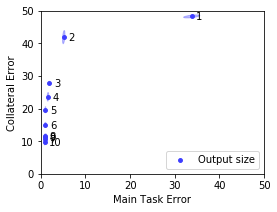

In [67]:
draw_pareto(main_results, collateral_results)

## 4.3 When the collateral model is a CNN

We perform the same experiment but with the collateral model being a CNN, to see is we observ similar behaviours.

In [9]:
class CollateralNet(nn.Module):
    def __init__(self):
        super(CollateralNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, PRIVATE_OUTPUT_SIZE, bias=False)

        # --- Junction
        self.char_jct = nn.Linear(PRIVATE_OUTPUT_SIZE, 784)

        # --- CNN for chars
        self.char_conv1 = nn.Conv2d(1, 20, 5, 1)
        self.char_conv2 = nn.Conv2d(20, 50, 5, 1)
        self.char_fc1 = nn.Linear(4 * 4 * 50, 500)
        self.char_fc2 = nn.Linear(500, N_CHARS)

        # --- Junction
        self.jct = nn.Linear(PRIVATE_OUTPUT_SIZE, 784)

        # --- CNN for families
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, N_FONTS)

    def quad(self, x):
        # --- Quadratic
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x

    def char_net(self, x):
        # --- Junction
        x = self.char_jct(x)
        x = x.view(-1, 1, 28, 28)

        # --- CNN
        x = F.relu(self.char_conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.char_conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.char_fc1(x))
        x = self.char_fc2(x)
        return x

    def font_net(self, x):
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)

        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.char_net(x)
        return F.log_softmax(x, dim=1)

    def forward_font(self, x):
        x = self.quad(x)
        x = self.font_net(x)
        return F.log_softmax(x, dim=1)
    
    # We add the ability to freeze some layers to ensure that the collateral task does
    # not modify the quadratic net
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.char_jct, self.char_fc1, self.char_fc2, self.char_conv1, self.char_conv2]
        elif net == 'font':
            layers = [self.jct, self.fc1, self.fc2, self.conv1, self.conv2]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params

    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False

    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True
    
    

In [10]:
cnn_results = {}
for cv in list(range(7)):
    for PRIVATE_OUTPUT_SIZE in [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]:
        print('\n -----', PRIVATE_OUTPUT_SIZE)
        model = CollateralNet()
        test_perfs_char_perturbate, test_perfs_font_perturbate = dual_learning_phase(model, cv)
        cnn_results[f"Main task with output size {cv} {PRIVATE_OUTPUT_SIZE}"] = test_perfs_char_perturbate
        cnn_results[f"Collateral task withoutput size {cv} {PRIVATE_OUTPUT_SIZE}"] = test_perfs_font_perturbate


 ----- 10
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.298993 Loss Font: 0.691049
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 2.196909 Loss Font: 0.692307
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 1.646312 Loss Font: 0.715448
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.709882 Loss Font: 0.622569

Test set: Accuracy Char : 7828/10000 (78.28%)
          Accuracy Font : 6271/10000 (62.71%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.724810 Loss Font: 0.610570
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.450109 Loss Font: 0.551580
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.145862 Loss Font: 0.430696
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.100970 Loss Font: 0.456218

Test set: Accuracy Char : 9391/10000 (93.91%)
          Accuracy Font : 7809/10000 (78.09%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.216265 Loss Font: 0.451827
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.086330 Loss Font: 0.266061
Train Epoch: 3 [38


Test set: Accuracy Char : 7967/10000 (79.67%)
          Accuracy Font : 6210/10000 (62.10%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.633548 Loss Font: 0.593875
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.417972 Loss Font: 0.532767
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.140884 Loss Font: 0.492598
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.166223 Loss Font: 0.433182

Test set: Accuracy Char : 9473/10000 (94.73%)
          Accuracy Font : 7663/10000 (76.63%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.161470 Loss Font: 0.481584
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.067538 Loss Font: 0.412270
Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.043501 Loss Font: 0.318145
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.042127 Loss Font: 0.370430

Test set: Accuracy Char : 9768/10000 (97.68%)
          Accuracy Font : 8518/10000 (85.18%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.151850 Loss Font: 0.341269
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.067242 Loss F

Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.065294 Loss Font: 0.490735

Test set: Accuracy Char : 9208/10000 (92.08%)
          Accuracy Font : 7029/10000 (70.29%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.166943 Loss Font: 0.527951
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.046938 Loss Font: 0.450149
Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.052767 Loss Font: 0.422488
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.038403 Loss Font: 0.475466

Test set: Accuracy Char : 9745/10000 (97.45%)
          Accuracy Font : 8190/10000 (81.90%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.168124 Loss Font: 0.375011
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.028033 Loss Font: 0.412460
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.039311 Loss Font: 0.478806
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.026355 Loss Font: 0.493714

Test set: Accuracy Char : 9815/10000 (98.15%)
          Accuracy Font : 8100/10000 (81.00%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.111152 Loss F

Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.132836 Loss Font: 0.583401
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.057557 Loss Font: 0.460924

Test set: Accuracy Char : 9737/10000 (97.37%)
          Accuracy Font : 7267/10000 (72.67%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.168607 Loss Font: 0.504462
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.035193 Loss Font: 0.488066
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.093493 Loss Font: 0.490401
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.014455 Loss Font: 0.570302

Test set: Accuracy Char : 9764/10000 (97.64%)
          Accuracy Font : 7260/10000 (72.60%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.165263 Loss Font: 0.537626
Train Epoch: 5 [19200/60000 (32%)]	Loss Char: 0.044633 Loss Font: 0.465960
Train Epoch: 5 [38400/60000 (64%)]	Loss Char: 0.091303 Loss Font: 0.590385
Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.062182 Loss Font: 0.507443

Test set: Accuracy Char : 9832/10000 (98.32%)
          Accuracy Font : 7

Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.176624 Loss Font: 0.681730
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.186301 Loss Font: 0.725271
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.179394 Loss Font: 0.684964

Test set: Accuracy Char : 9278/10000 (92.78%)
          Accuracy Font : 5312/10000 (53.12%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.241163 Loss Font: 0.688086
Train Epoch: 5 [19200/60000 (32%)]	Loss Char: 0.053920 Loss Font: 0.671126
Train Epoch: 5 [38400/60000 (64%)]	Loss Char: 0.272510 Loss Font: 0.702766
Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.153520 Loss Font: 0.675506

Test set: Accuracy Char : 9387/10000 (93.87%)
          Accuracy Font : 5521/10000 (55.21%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.267634 Loss Font: 0.676423
Train Epoch: 6 [19200/60000 (32%)]	Loss Char: 0.203784 Loss Font: 0.664204
Train Epoch: 6 [38400/60000 (64%)]	Loss Char: 0.148420 Loss Font: 0.704279
Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.119752 Loss Font: 0.690459

Train Epoch: 5 [19200/60000 (32%)]	Loss Char: 0.018514 Loss Font: 0.310974
Train Epoch: 5 [38400/60000 (64%)]	Loss Char: 0.031040 Loss Font: 0.384805
Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.023123 Loss Font: 0.181747

Test set: Accuracy Char : 9857/10000 (98.57%)
          Accuracy Font : 8989/10000 (89.89%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.041800 Loss Font: 0.173248
Train Epoch: 6 [19200/60000 (32%)]	Loss Char: 0.031171 Loss Font: 0.188494
Train Epoch: 6 [38400/60000 (64%)]	Loss Char: 0.004616 Loss Font: 0.175017
Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.010021 Loss Font: 0.198309

Test set: Accuracy Char : 9905/10000 (99.05%)
          Accuracy Font : 9003/10000 (90.03%)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.039015 Loss Font: 0.234610
Train Epoch: 7 [19200/60000 (32%)]	Loss Char: 0.002173 Loss Font: 0.106973
Train Epoch: 7 [38400/60000 (64%)]	Loss Char: 0.003819 Loss Font: 0.247311
Train Epoch: 7 [57600/60000 (96%)]	Loss Char: 0.011301 Loss Font: 0.167210

Train Epoch: 6 [19200/60000 (32%)]	Loss Char: 0.037377 Loss Font: 0.258397
Train Epoch: 6 [38400/60000 (64%)]	Loss Char: 0.001885 Loss Font: 0.165177
Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.003058 Loss Font: 0.415436

Test set: Accuracy Char : 9904/10000 (99.04%)
          Accuracy Font : 8861/10000 (88.61%)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.011887 Loss Font: 0.250364
Train Epoch: 7 [19200/60000 (32%)]	Loss Char: 0.004063 Loss Font: 0.198056
Train Epoch: 7 [38400/60000 (64%)]	Loss Char: 0.007857 Loss Font: 0.284497
Train Epoch: 7 [57600/60000 (96%)]	Loss Char: 0.006375 Loss Font: 0.219669

Test set: Accuracy Char : 9911/10000 (99.11%)
          Accuracy Font : 8876/10000 (88.76%)
Train Epoch: 8 [0/60000 (0%)]	Loss Char: 0.004342 Loss Font: 0.229221
Train Epoch: 8 [19200/60000 (32%)]	Loss Char: 0.003589 Loss Font: 0.264256
Train Epoch: 8 [38400/60000 (64%)]	Loss Char: 0.007813 Loss Font: 0.164001
Train Epoch: 8 [57600/60000 (96%)]	Loss Char: 0.039067 Loss Font: 0.218020

Train Epoch: 7 [19200/60000 (32%)]	Loss Char: 0.003731 Loss Font: 0.289381
Train Epoch: 7 [38400/60000 (64%)]	Loss Char: 0.008059 Loss Font: 0.393410
Train Epoch: 7 [57600/60000 (96%)]	Loss Char: 0.010476 Loss Font: 0.333938

Test set: Accuracy Char : 9891/10000 (98.91%)
          Accuracy Font : 8498/10000 (84.98%)
Train Epoch: 8 [0/60000 (0%)]	Loss Char: 0.004581 Loss Font: 0.375994
Train Epoch: 8 [19200/60000 (32%)]	Loss Char: 0.002916 Loss Font: 0.324405
Train Epoch: 8 [38400/60000 (64%)]	Loss Char: 0.032023 Loss Font: 0.316424
Train Epoch: 8 [57600/60000 (96%)]	Loss Char: 0.040096 Loss Font: 0.253134

Test set: Accuracy Char : 9912/10000 (99.12%)
          Accuracy Font : 8541/10000 (85.41%)
Train Epoch: 9 [0/60000 (0%)]	Loss Char: 0.018877 Loss Font: 0.325253
Train Epoch: 9 [19200/60000 (32%)]	Loss Char: 0.001999 Loss Font: 0.346906
Train Epoch: 9 [38400/60000 (64%)]	Loss Char: 0.001690 Loss Font: 0.364695
Train Epoch: 9 [57600/60000 (96%)]	Loss Char: 0.007012 Loss Font: 0.274678

Train Epoch: 8 [19200/60000 (32%)]	Loss Char: 0.001804 Loss Font: 0.474083
Train Epoch: 8 [38400/60000 (64%)]	Loss Char: 0.059197 Loss Font: 0.423382
Train Epoch: 8 [57600/60000 (96%)]	Loss Char: 0.040761 Loss Font: 0.376758

Test set: Accuracy Char : 9847/10000 (98.47%)
          Accuracy Font : 7685/10000 (76.85%)
Train Epoch: 9 [0/60000 (0%)]	Loss Char: 0.162326 Loss Font: 0.567969
Train Epoch: 9 [19200/60000 (32%)]	Loss Char: 0.015420 Loss Font: 0.454272
Train Epoch: 9 [38400/60000 (64%)]	Loss Char: 0.006978 Loss Font: 0.502255
Train Epoch: 9 [57600/60000 (96%)]	Loss Char: 0.006194 Loss Font: 0.408883

Test set: Accuracy Char : 9860/10000 (98.60%)
          Accuracy Font : 7674/10000 (76.74%)
Train Epoch: 10 [0/60000 (0%)]	Loss Char: 0.009691 Loss Font: 0.337034
Train Epoch: 10 [19200/60000 (32%)]	Loss Char: 0.004863 Loss Font: 0.370818
Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.039221 Loss Font: 0.570612
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.001792 Loss Font: 0.43

Train Epoch: 9 [19200/60000 (32%)]	Loss Char: 0.243826 Loss Font: 0.658980
Train Epoch: 9 [38400/60000 (64%)]	Loss Char: 0.024556 Loss Font: 0.662552
Train Epoch: 9 [57600/60000 (96%)]	Loss Char: 0.064768 Loss Font: 0.660518

Test set: Accuracy Char : 9469/10000 (94.69%)
          Accuracy Font : 5416/10000 (54.16%)
Train Epoch: 10 [0/60000 (0%)]	Loss Char: 0.097082 Loss Font: 0.651646
Train Epoch: 10 [19200/60000 (32%)]	Loss Char: 0.113257 Loss Font: 0.681478
Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.122970 Loss Font: 0.679316
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.106850 Loss Font: 0.686656

Test set: Accuracy Char : 9570/10000 (95.70%)
          Accuracy Font : 5723/10000 (57.23%)

 ----- 1
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.304233 Loss Font: 0.696458
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 2.151150 Loss Font: 0.691659
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 1.475827 Loss Font: 0.704628
Train Epoc

Train Epoch: 10 [19200/60000 (32%)]	Loss Char: 0.000384 Loss Font: 0.225023
Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.004331 Loss Font: 0.303007
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.002389 Loss Font: 0.256129

Test set: Accuracy Char : 9927/10000 (99.27%)
          Accuracy Font : 9030/10000 (90.30%)

 ----- 9
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.303685 Loss Font: 0.695681
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 2.290545 Loss Font: 0.696938
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 1.889262 Loss Font: 0.733253
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.682530 Loss Font: 0.621879

Test set: Accuracy Char : 7929/10000 (79.29%)
          Accuracy Font : 6705/10000 (67.05%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.714099 Loss Font: 0.631682
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.391070 Loss Font: 0.514550
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.186950 Loss Font: 0.495042
Train Epoch

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.304368 Loss Font: 0.692868
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 2.268410 Loss Font: 0.686652
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 1.635769 Loss Font: 0.673947
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.465233 Loss Font: 0.600721

Test set: Accuracy Char : 8365/10000 (83.65%)
          Accuracy Font : 6674/10000 (66.74%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.606117 Loss Font: 0.654928
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.371876 Loss Font: 0.571971
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.164471 Loss Font: 0.435146
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.058970 Loss Font: 0.381302

Test set: Accuracy Char : 9608/10000 (96.08%)
          Accuracy Font : 8096/10000 (80.96%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.083314 Loss Font: 0.321847
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.042123 Loss Font: 0.481603
Train Epoch: 3 [38400/60000 (


Test set: Accuracy Char : 8359/10000 (83.59%)
          Accuracy Font : 6524/10000 (65.24%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.568783 Loss Font: 0.666767
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.345692 Loss Font: 0.583592
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.227115 Loss Font: 0.601542
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.093618 Loss Font: 0.621758

Test set: Accuracy Char : 9657/10000 (96.57%)
          Accuracy Font : 7281/10000 (72.81%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.072105 Loss Font: 0.506048
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.030838 Loss Font: 0.444331
Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.028106 Loss Font: 0.667308
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.046082 Loss Font: 0.574217

Test set: Accuracy Char : 9784/10000 (97.84%)
          Accuracy Font : 7686/10000 (76.86%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.174829 Loss Font: 0.421637
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.024022 Loss F

Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.063678 Loss Font: 0.615167

Test set: Accuracy Char : 9435/10000 (94.35%)
          Accuracy Font : 6641/10000 (66.41%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.065943 Loss Font: 0.527133
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.053778 Loss Font: 0.494398
Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.022029 Loss Font: 0.633079
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.048639 Loss Font: 0.626229

Test set: Accuracy Char : 9675/10000 (96.75%)
          Accuracy Font : 6974/10000 (69.74%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.219873 Loss Font: 0.522883
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.019395 Loss Font: 0.551234
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.086918 Loss Font: 0.698592
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.060270 Loss Font: 0.567806

Test set: Accuracy Char : 9680/10000 (96.80%)
          Accuracy Font : 6936/10000 (69.36%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.014951 Loss F

Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.824239 Loss Font: 0.694054
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.835250 Loss Font: 0.668632

Test set: Accuracy Char : 6145/10000 (61.45%)
          Accuracy Font : 5087/10000 (50.87%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 1.138358 Loss Font: 0.683671
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.886446 Loss Font: 0.705364
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.889418 Loss Font: 0.692843
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.857838 Loss Font: 0.700840

Test set: Accuracy Char : 6403/10000 (64.03%)
          Accuracy Font : 5244/10000 (52.44%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.875266 Loss Font: 0.685309
Train Epoch: 5 [19200/60000 (32%)]	Loss Char: 1.032632 Loss Font: 0.690382
Train Epoch: 5 [38400/60000 (64%)]	Loss Char: 1.015182 Loss Font: 0.702775
Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.944942 Loss Font: 0.705146

Test set: Accuracy Char : 6255/10000 (62.55%)
          Accuracy Font : 5

Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.029893 Loss Font: 0.351118
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.010403 Loss Font: 0.370704
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.032688 Loss Font: 0.349958

Test set: Accuracy Char : 9817/10000 (98.17%)
          Accuracy Font : 8474/10000 (84.74%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.011586 Loss Font: 0.401436
Train Epoch: 5 [19200/60000 (32%)]	Loss Char: 0.005316 Loss Font: 0.367948
Train Epoch: 5 [38400/60000 (64%)]	Loss Char: 0.005021 Loss Font: 0.222827
Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.084427 Loss Font: 0.272681

Test set: Accuracy Char : 9850/10000 (98.50%)
          Accuracy Font : 8671/10000 (86.71%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.021024 Loss Font: 0.227290
Train Epoch: 6 [19200/60000 (32%)]	Loss Char: 0.010891 Loss Font: 0.341839
Train Epoch: 6 [38400/60000 (64%)]	Loss Char: 0.005109 Loss Font: 0.299427
Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.002744 Loss Font: 0.319094

Train Epoch: 5 [19200/60000 (32%)]	Loss Char: 0.004239 Loss Font: 0.193085
Train Epoch: 5 [38400/60000 (64%)]	Loss Char: 0.019841 Loss Font: 0.300884
Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.028481 Loss Font: 0.259378

Test set: Accuracy Char : 9872/10000 (98.72%)
          Accuracy Font : 8834/10000 (88.34%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.019971 Loss Font: 0.169857
Train Epoch: 6 [19200/60000 (32%)]	Loss Char: 0.028560 Loss Font: 0.314151
Train Epoch: 6 [38400/60000 (64%)]	Loss Char: 0.004878 Loss Font: 0.160555
Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.002650 Loss Font: 0.217252

Test set: Accuracy Char : 9881/10000 (98.81%)
          Accuracy Font : 8900/10000 (89.00%)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.005879 Loss Font: 0.234006
Train Epoch: 7 [19200/60000 (32%)]	Loss Char: 0.003314 Loss Font: 0.184394
Train Epoch: 7 [38400/60000 (64%)]	Loss Char: 0.004448 Loss Font: 0.401688
Train Epoch: 7 [57600/60000 (96%)]	Loss Char: 0.024926 Loss Font: 0.190597

Train Epoch: 6 [19200/60000 (32%)]	Loss Char: 0.014150 Loss Font: 0.410603
Train Epoch: 6 [38400/60000 (64%)]	Loss Char: 0.016085 Loss Font: 0.340367
Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.004196 Loss Font: 0.418421

Test set: Accuracy Char : 9866/10000 (98.66%)
          Accuracy Font : 8030/10000 (80.30%)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.002758 Loss Font: 0.443939
Train Epoch: 7 [19200/60000 (32%)]	Loss Char: 0.013873 Loss Font: 0.300772
Train Epoch: 7 [38400/60000 (64%)]	Loss Char: 0.008901 Loss Font: 0.457045
Train Epoch: 7 [57600/60000 (96%)]	Loss Char: 0.066658 Loss Font: 0.299199

Test set: Accuracy Char : 9845/10000 (98.45%)
          Accuracy Font : 7904/10000 (79.04%)
Train Epoch: 8 [0/60000 (0%)]	Loss Char: 0.011778 Loss Font: 0.395323
Train Epoch: 8 [19200/60000 (32%)]	Loss Char: 0.001288 Loss Font: 0.389889
Train Epoch: 8 [38400/60000 (64%)]	Loss Char: 0.002158 Loss Font: 0.278981
Train Epoch: 8 [57600/60000 (96%)]	Loss Char: 0.063733 Loss Font: 0.304257

Train Epoch: 7 [19200/60000 (32%)]	Loss Char: 0.012917 Loss Font: 0.487980
Train Epoch: 7 [38400/60000 (64%)]	Loss Char: 0.025409 Loss Font: 0.553640
Train Epoch: 7 [57600/60000 (96%)]	Loss Char: 0.044675 Loss Font: 0.393937

Test set: Accuracy Char : 9793/10000 (97.93%)
          Accuracy Font : 7289/10000 (72.89%)
Train Epoch: 8 [0/60000 (0%)]	Loss Char: 0.006940 Loss Font: 0.516091
Train Epoch: 8 [19200/60000 (32%)]	Loss Char: 0.001999 Loss Font: 0.456023
Train Epoch: 8 [38400/60000 (64%)]	Loss Char: 0.011497 Loss Font: 0.456171
Train Epoch: 8 [57600/60000 (96%)]	Loss Char: 0.097494 Loss Font: 0.505700

Test set: Accuracy Char : 9756/10000 (97.56%)
          Accuracy Font : 7361/10000 (73.61%)
Train Epoch: 9 [0/60000 (0%)]	Loss Char: 0.007032 Loss Font: 0.567859
Train Epoch: 9 [19200/60000 (32%)]	Loss Char: 0.018972 Loss Font: 0.430188
Train Epoch: 9 [38400/60000 (64%)]	Loss Char: 0.027295 Loss Font: 0.577842
Train Epoch: 9 [57600/60000 (96%)]	Loss Char: 0.042333 Loss Font: 0.529601

Train Epoch: 8 [19200/60000 (32%)]	Loss Char: 0.787895 Loss Font: 0.681707
Train Epoch: 8 [38400/60000 (64%)]	Loss Char: 0.816856 Loss Font: 0.686913
Train Epoch: 8 [57600/60000 (96%)]	Loss Char: 0.981479 Loss Font: 0.690840

Test set: Accuracy Char : 6676/10000 (66.76%)
          Accuracy Font : 5177/10000 (51.77%)
Train Epoch: 9 [0/60000 (0%)]	Loss Char: 0.677543 Loss Font: 0.688349
Train Epoch: 9 [19200/60000 (32%)]	Loss Char: 0.734389 Loss Font: 0.682871
Train Epoch: 9 [38400/60000 (64%)]	Loss Char: 0.755923 Loss Font: 0.676006
Train Epoch: 9 [57600/60000 (96%)]	Loss Char: 0.749934 Loss Font: 0.692379

Test set: Accuracy Char : 6283/10000 (62.83%)
          Accuracy Font : 5262/10000 (52.62%)
Train Epoch: 10 [0/60000 (0%)]	Loss Char: 1.139219 Loss Font: 0.697056
Train Epoch: 10 [19200/60000 (32%)]	Loss Char: 0.752458 Loss Font: 0.706949
Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.780634 Loss Font: 0.694970
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.958014 Loss Font: 0.69

Train Epoch: 9 [19200/60000 (32%)]	Loss Char: 0.000742 Loss Font: 0.218504
Train Epoch: 9 [38400/60000 (64%)]	Loss Char: 0.002940 Loss Font: 0.237711
Train Epoch: 9 [57600/60000 (96%)]	Loss Char: 0.003486 Loss Font: 0.252424

Test set: Accuracy Char : 9916/10000 (99.16%)
          Accuracy Font : 9100/10000 (91.00%)
Train Epoch: 10 [0/60000 (0%)]	Loss Char: 0.000806 Loss Font: 0.141136
Train Epoch: 10 [19200/60000 (32%)]	Loss Char: 0.025697 Loss Font: 0.298448
Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.000314 Loss Font: 0.286254
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.002924 Loss Font: 0.318136

Test set: Accuracy Char : 9916/10000 (99.16%)
          Accuracy Font : 9077/10000 (90.77%)

 ----- 8
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.304290 Loss Font: 0.690018
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 2.290861 Loss Font: 0.690689
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 1.577820 Loss Font: 0.662827
Train Epoc

Train Epoch: 10 [19200/60000 (32%)]	Loss Char: 0.002648 Loss Font: 0.241380
Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.000484 Loss Font: 0.322099
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.000481 Loss Font: 0.283230

Test set: Accuracy Char : 9916/10000 (99.16%)
          Accuracy Font : 8943/10000 (89.43%)

 ----- 6
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.311928 Loss Font: 0.690800
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 2.309970 Loss Font: 0.692118
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 2.114499 Loss Font: 0.684998
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 1.232321 Loss Font: 0.608920

Test set: Accuracy Char : 7373/10000 (73.73%)
          Accuracy Font : 6518/10000 (65.18%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.861618 Loss Font: 0.640472
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.335976 Loss Font: 0.646255
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.310549 Loss Font: 0.454357
Train Epoch

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.307030 Loss Font: 0.692414
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 2.263013 Loss Font: 0.693326
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 1.194427 Loss Font: 0.634462
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.546743 Loss Font: 0.611697

Test set: Accuracy Char : 8628/10000 (86.28%)
          Accuracy Font : 6740/10000 (67.40%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.518934 Loss Font: 0.654899
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.232533 Loss Font: 0.578577
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.212074 Loss Font: 0.504433
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.062640 Loss Font: 0.588598

Test set: Accuracy Char : 9577/10000 (95.77%)
          Accuracy Font : 7189/10000 (71.89%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.166710 Loss Font: 0.520906
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.051445 Loss Font: 0.442647
Train Epoch: 3 [38400/60000 (


Test set: Accuracy Char : 7616/10000 (76.16%)
          Accuracy Font : 5179/10000 (51.79%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.803272 Loss Font: 0.667869
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.397692 Loss Font: 0.697435
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.567866 Loss Font: 0.712555
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.220731 Loss Font: 0.708155

Test set: Accuracy Char : 9024/10000 (90.24%)
          Accuracy Font : 5678/10000 (56.78%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.475766 Loss Font: 0.678053
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.223851 Loss Font: 0.675546
Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.182190 Loss Font: 0.694987
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.187320 Loss Font: 0.685814

Test set: Accuracy Char : 9206/10000 (92.06%)
          Accuracy Font : 5564/10000 (55.64%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.266342 Loss Font: 0.680912
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.199502 Loss F

Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.090022 Loss Font: 0.484019

Test set: Accuracy Char : 9537/10000 (95.37%)
          Accuracy Font : 7868/10000 (78.68%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.191204 Loss Font: 0.460897
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.098839 Loss Font: 0.433913
Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.026970 Loss Font: 0.379478
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.054702 Loss Font: 0.343756

Test set: Accuracy Char : 9746/10000 (97.46%)
          Accuracy Font : 8443/10000 (84.43%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.040550 Loss Font: 0.355387
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.093360 Loss Font: 0.344765
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.024749 Loss Font: 0.341342
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.035142 Loss Font: 0.282213

Test set: Accuracy Char : 9818/10000 (98.18%)
          Accuracy Font : 8578/10000 (85.78%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.128774 Loss F

Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.020356 Loss Font: 0.381534
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.074604 Loss Font: 0.358975

Test set: Accuracy Char : 9761/10000 (97.61%)
          Accuracy Font : 8142/10000 (81.42%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.007653 Loss Font: 0.372718
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.031338 Loss Font: 0.518634
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.071739 Loss Font: 0.254607
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.037246 Loss Font: 0.321916

Test set: Accuracy Char : 9820/10000 (98.20%)
          Accuracy Font : 8393/10000 (83.93%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.029537 Loss Font: 0.355001
Train Epoch: 5 [19200/60000 (32%)]	Loss Char: 0.039442 Loss Font: 0.303431
Train Epoch: 5 [38400/60000 (64%)]	Loss Char: 0.021036 Loss Font: 0.269640
Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.004920 Loss Font: 0.218343

Test set: Accuracy Char : 9883/10000 (98.83%)
          Accuracy Font : 8

Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.072981 Loss Font: 0.536012
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.014540 Loss Font: 0.340242
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.035201 Loss Font: 0.429009

Test set: Accuracy Char : 9806/10000 (98.06%)
          Accuracy Font : 8060/10000 (80.60%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.031185 Loss Font: 0.413671
Train Epoch: 5 [19200/60000 (32%)]	Loss Char: 0.049121 Loss Font: 0.399348
Train Epoch: 5 [38400/60000 (64%)]	Loss Char: 0.052821 Loss Font: 0.333924
Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.003653 Loss Font: 0.346845

Test set: Accuracy Char : 9865/10000 (98.65%)
          Accuracy Font : 8140/10000 (81.40%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.097754 Loss Font: 0.381262
Train Epoch: 6 [19200/60000 (32%)]	Loss Char: 0.013511 Loss Font: 0.381011
Train Epoch: 6 [38400/60000 (64%)]	Loss Char: 0.008791 Loss Font: 0.280524
Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.001697 Loss Font: 0.230205

Train Epoch: 5 [19200/60000 (32%)]	Loss Char: 0.069762 Loss Font: 0.525620
Train Epoch: 5 [38400/60000 (64%)]	Loss Char: 0.045090 Loss Font: 0.508790
Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.010253 Loss Font: 0.416397

Test set: Accuracy Char : 9792/10000 (97.92%)
          Accuracy Font : 7344/10000 (73.44%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.086820 Loss Font: 0.446828
Train Epoch: 6 [19200/60000 (32%)]	Loss Char: 0.103173 Loss Font: 0.510706
Train Epoch: 6 [38400/60000 (64%)]	Loss Char: 0.100975 Loss Font: 0.478954
Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.007815 Loss Font: 0.493635

Test set: Accuracy Char : 9792/10000 (97.92%)
          Accuracy Font : 7490/10000 (74.90%)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.010143 Loss Font: 0.480119
Train Epoch: 7 [19200/60000 (32%)]	Loss Char: 0.007554 Loss Font: 0.476419
Train Epoch: 7 [38400/60000 (64%)]	Loss Char: 0.015703 Loss Font: 0.445962
Train Epoch: 7 [57600/60000 (96%)]	Loss Char: 0.077942 Loss Font: 0.433044

Train Epoch: 6 [19200/60000 (32%)]	Loss Char: 0.288164 Loss Font: 0.720438
Train Epoch: 6 [38400/60000 (64%)]	Loss Char: 0.086768 Loss Font: 0.676330
Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.198136 Loss Font: 0.677398

Test set: Accuracy Char : 9433/10000 (94.33%)
          Accuracy Font : 6155/10000 (61.55%)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.138234 Loss Font: 0.674498
Train Epoch: 7 [19200/60000 (32%)]	Loss Char: 0.094857 Loss Font: 0.667826
Train Epoch: 7 [38400/60000 (64%)]	Loss Char: 0.188645 Loss Font: 0.641963
Train Epoch: 7 [57600/60000 (96%)]	Loss Char: 0.065398 Loss Font: 0.632462

Test set: Accuracy Char : 9578/10000 (95.78%)
          Accuracy Font : 5755/10000 (57.55%)
Train Epoch: 8 [0/60000 (0%)]	Loss Char: 0.181021 Loss Font: 0.669175
Train Epoch: 8 [19200/60000 (32%)]	Loss Char: 0.039058 Loss Font: 0.641768
Train Epoch: 8 [38400/60000 (64%)]	Loss Char: 0.214191 Loss Font: 0.627371
Train Epoch: 8 [57600/60000 (96%)]	Loss Char: 0.062827 Loss Font: 0.699038

Train Epoch: 7 [19200/60000 (32%)]	Loss Char: 0.011921 Loss Font: 0.150179
Train Epoch: 7 [38400/60000 (64%)]	Loss Char: 0.002561 Loss Font: 0.265471
Train Epoch: 7 [57600/60000 (96%)]	Loss Char: 0.014237 Loss Font: 0.247583

Test set: Accuracy Char : 9877/10000 (98.77%)
          Accuracy Font : 9091/10000 (90.91%)
Train Epoch: 8 [0/60000 (0%)]	Loss Char: 0.004186 Loss Font: 0.272940
Train Epoch: 8 [19200/60000 (32%)]	Loss Char: 0.001920 Loss Font: 0.188698
Train Epoch: 8 [38400/60000 (64%)]	Loss Char: 0.043211 Loss Font: 0.206909
Train Epoch: 8 [57600/60000 (96%)]	Loss Char: 0.006341 Loss Font: 0.233270

Test set: Accuracy Char : 9895/10000 (98.95%)
          Accuracy Font : 9086/10000 (90.86%)
Train Epoch: 9 [0/60000 (0%)]	Loss Char: 0.000793 Loss Font: 0.197215
Train Epoch: 9 [19200/60000 (32%)]	Loss Char: 0.006936 Loss Font: 0.132313
Train Epoch: 9 [38400/60000 (64%)]	Loss Char: 0.007861 Loss Font: 0.153374
Train Epoch: 9 [57600/60000 (96%)]	Loss Char: 0.008586 Loss Font: 0.125448

Train Epoch: 8 [19200/60000 (32%)]	Loss Char: 0.003515 Loss Font: 0.293434
Train Epoch: 8 [38400/60000 (64%)]	Loss Char: 0.033083 Loss Font: 0.208699
Train Epoch: 8 [57600/60000 (96%)]	Loss Char: 0.001997 Loss Font: 0.288179

Test set: Accuracy Char : 9768/10000 (97.68%)
          Accuracy Font : 8364/10000 (83.64%)
Train Epoch: 9 [0/60000 (0%)]	Loss Char: 0.010425 Loss Font: 0.281709
Train Epoch: 9 [19200/60000 (32%)]	Loss Char: 0.001649 Loss Font: 0.245221
Train Epoch: 9 [38400/60000 (64%)]	Loss Char: 0.004671 Loss Font: 0.172016
Train Epoch: 9 [57600/60000 (96%)]	Loss Char: 0.012344 Loss Font: 0.155508

Test set: Accuracy Char : 9891/10000 (98.91%)
          Accuracy Font : 8811/10000 (88.11%)
Train Epoch: 10 [0/60000 (0%)]	Loss Char: 0.003406 Loss Font: 0.277183
Train Epoch: 10 [19200/60000 (32%)]	Loss Char: 0.001095 Loss Font: 0.314345
Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.001131 Loss Font: 0.303655
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.002754 Loss Font: 0.25

Train Epoch: 9 [19200/60000 (32%)]	Loss Char: 0.005974 Loss Font: 0.321851
Train Epoch: 9 [38400/60000 (64%)]	Loss Char: 0.005065 Loss Font: 0.279805
Train Epoch: 9 [57600/60000 (96%)]	Loss Char: 0.020530 Loss Font: 0.241175

Test set: Accuracy Char : 9879/10000 (98.79%)
          Accuracy Font : 8599/10000 (85.99%)
Train Epoch: 10 [0/60000 (0%)]	Loss Char: 0.002378 Loss Font: 0.355535
Train Epoch: 10 [19200/60000 (32%)]	Loss Char: 0.000649 Loss Font: 0.269992
Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.001459 Loss Font: 0.324005
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.002361 Loss Font: 0.400591

Test set: Accuracy Char : 9903/10000 (99.03%)
          Accuracy Font : 8666/10000 (86.66%)

 ----- 5
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.296087 Loss Font: 0.689494
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 2.286841 Loss Font: 0.690919
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 1.490018 Loss Font: 0.623646
Train Epoc

Train Epoch: 10 [19200/60000 (32%)]	Loss Char: 0.002291 Loss Font: 0.502865
Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.014586 Loss Font: 0.502038
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.015380 Loss Font: 0.491570

Test set: Accuracy Char : 9833/10000 (98.33%)
          Accuracy Font : 7584/10000 (75.84%)

 ----- 3
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.310564 Loss Font: 0.697306
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 2.188629 Loss Font: 0.697830
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 1.414246 Loss Font: 0.678672
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.577280 Loss Font: 0.625429

Test set: Accuracy Char : 8389/10000 (83.89%)
          Accuracy Font : 6448/10000 (64.48%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.446040 Loss Font: 0.646720
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.389876 Loss Font: 0.629385
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.351972 Loss Font: 0.555594
Train Epoch

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.293934 Loss Font: 0.696460
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 2.194678 Loss Font: 0.692041
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 1.480457 Loss Font: 0.690252
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 1.255141 Loss Font: 0.696069

Test set: Accuracy Char : 4720/10000 (47.20%)
          Accuracy Font : 5131/10000 (51.31%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 1.193294 Loss Font: 0.710435
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 1.145972 Loss Font: 0.683447
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 1.053284 Loss Font: 0.701332
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 1.120691 Loss Font: 0.688418

Test set: Accuracy Char : 5901/10000 (59.01%)
          Accuracy Font : 5004/10000 (50.04%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 1.098610 Loss Font: 0.693246
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.833504 Loss Font: 0.688815
Train Epoch: 3 [38400/60000 (

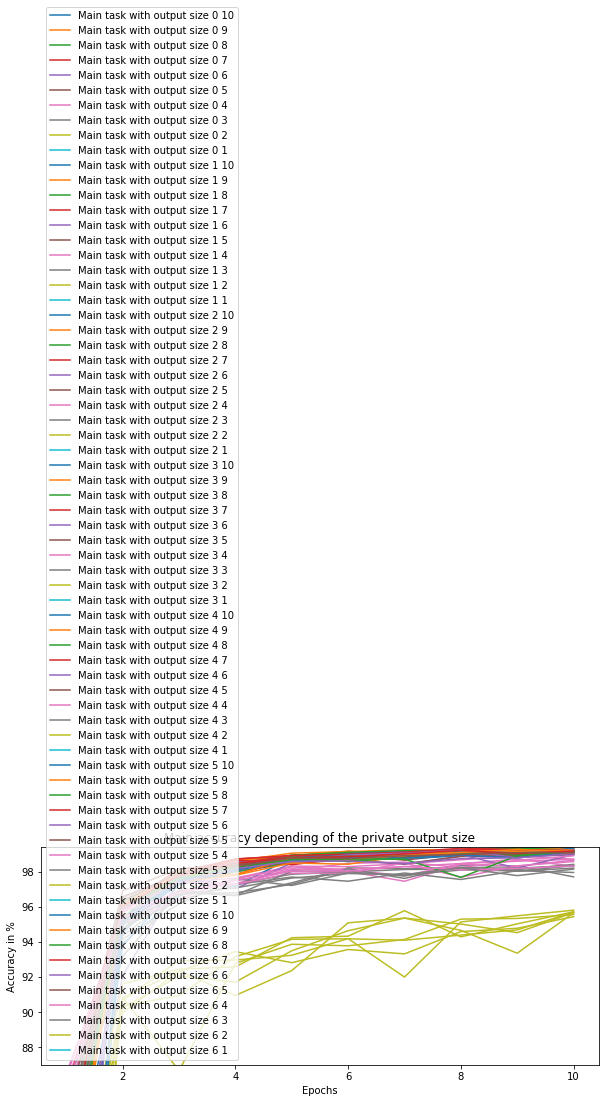

In [14]:
main_results = {k:v for k, v in cnn_results.items() if 'Main' in k}
show_results(main_results, title="Main accuracy depending of the private output size", ymin=87)

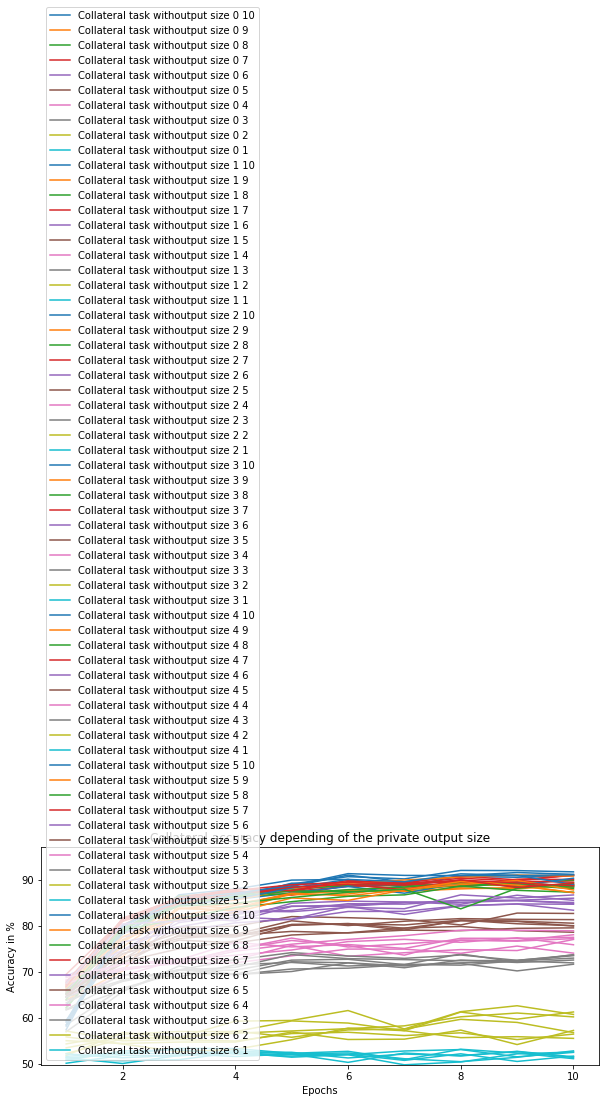

In [15]:
collateral_results = {k:v for k, v in cnn_results.items() if 'Collateral' in k}
show_results(collateral_results, title="Collateral accuracy depending of the private output size", ymax=97)

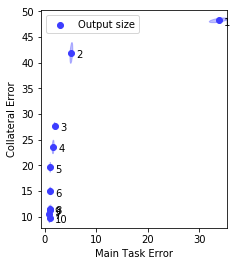

In [26]:
draw_pareto(main_results, collateral_results)

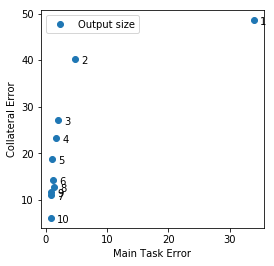

In [19]:
draw_pareto(main_results, collateral_results)